# Zero-Inflated TSB Model

After going through the fundamentals of the [TSB Method for Intermittent Time Series Forecasting in NumPyro](https://juanitorduz.github.io/tsb_numpyro/) in the previous notebook, we explore a variation of it that might be useful for certain applications. In a nutshell, We keep the same model structure of the TSB model, but we modify the likelihood function to account for the sparsity of the time series. Concretely, we replace the classic Gaussian likelihood function with a zero-inflated Negative Binomial likelihood function. One clear conceptual advantage of this approach that all our prediction and credible intervals will be non-negative.

---

## Model Specification

Recall that the **TSB method **is similar to the [Croston's method](https://juanitorduz.github.io/croston_numpyro/) in the sense that is constructs two different time series out of the original one and then forecast each of them separately, so that the final forecast is generated by combining the forecasts of the two time series. The main difference between the two methods is that the TSB method uses the demand probability instead of the demand periods. Let $y_{t}$ denote the input time series then the TSB method is specified by the following equations:

If $y_{t} > 0$, then

$$
\begin{align*}
z_{t + 1} & = \alpha y_{t} + (1 - \alpha) z_{t} \\
p_{t + 1} & = \beta + (1 - \beta) p_{t}
\end{align*}
$$

If $y_{t} = 0$, then

$$
\begin{align*}
z_{t + 1} & = z_{t} \\
p_{t + 1} & = (1 - \beta) p_{t}
\end{align*}
$$

where $z_{t}$ is the demand (level) of the time series at time $t$, $p_{t}$ is the probability of observing a non-zero demand at time $t$, and $\alpha$ and $\beta$ are the smoothing parameters. The forecast is then given by the product.

$$
\hat{y}_{t + 1} = z_{t} p_{t}
$$

Well, to be more precise, one generate predictions by sampling from the distribution:

$$
\hat{y}_{t + 1} \sim \text{Normal}(z_{t} p_{t}, \sigma^2)
$$

The idea behind the zero-inflated TSB model is to replace the Gaussian likelihood function with a [Zero-Inflated Negative Binomial](https://num.pyro.ai/en/stable/distributions.html#zeroinflatednegativebinomial2) likelihood function.

$$
\hat{y}_{t + 1} \sim \text{ZeroInflatedNegativeBinomial}(\text{mean}=z_{t}, \text{concentration}=\sigma, \text{gate}=1 - p_{t}),
$$

where the parameter `gate` is the probability of observing a zero demand at time $t$. Hence, it is natural to consider $1 - p_{t}$. Note that we use $z_{t}$ as the man since we account for the demand probability in the `gate` parameter.

---

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
import preliz as pz
import xarray as xr
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsforecast import StatsForecast
from statsforecast.models import TSB, CrostonOptimized
from statsforecast.utils import ConformalIntervals
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

---

## Generate Synthetic Data

We consider thee same synthetic data as in the previous post [TSB Method for Intermittent Time Series Forecasting in NumPyro](https://juanitorduz.github.io/tsb_numpyro/):

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

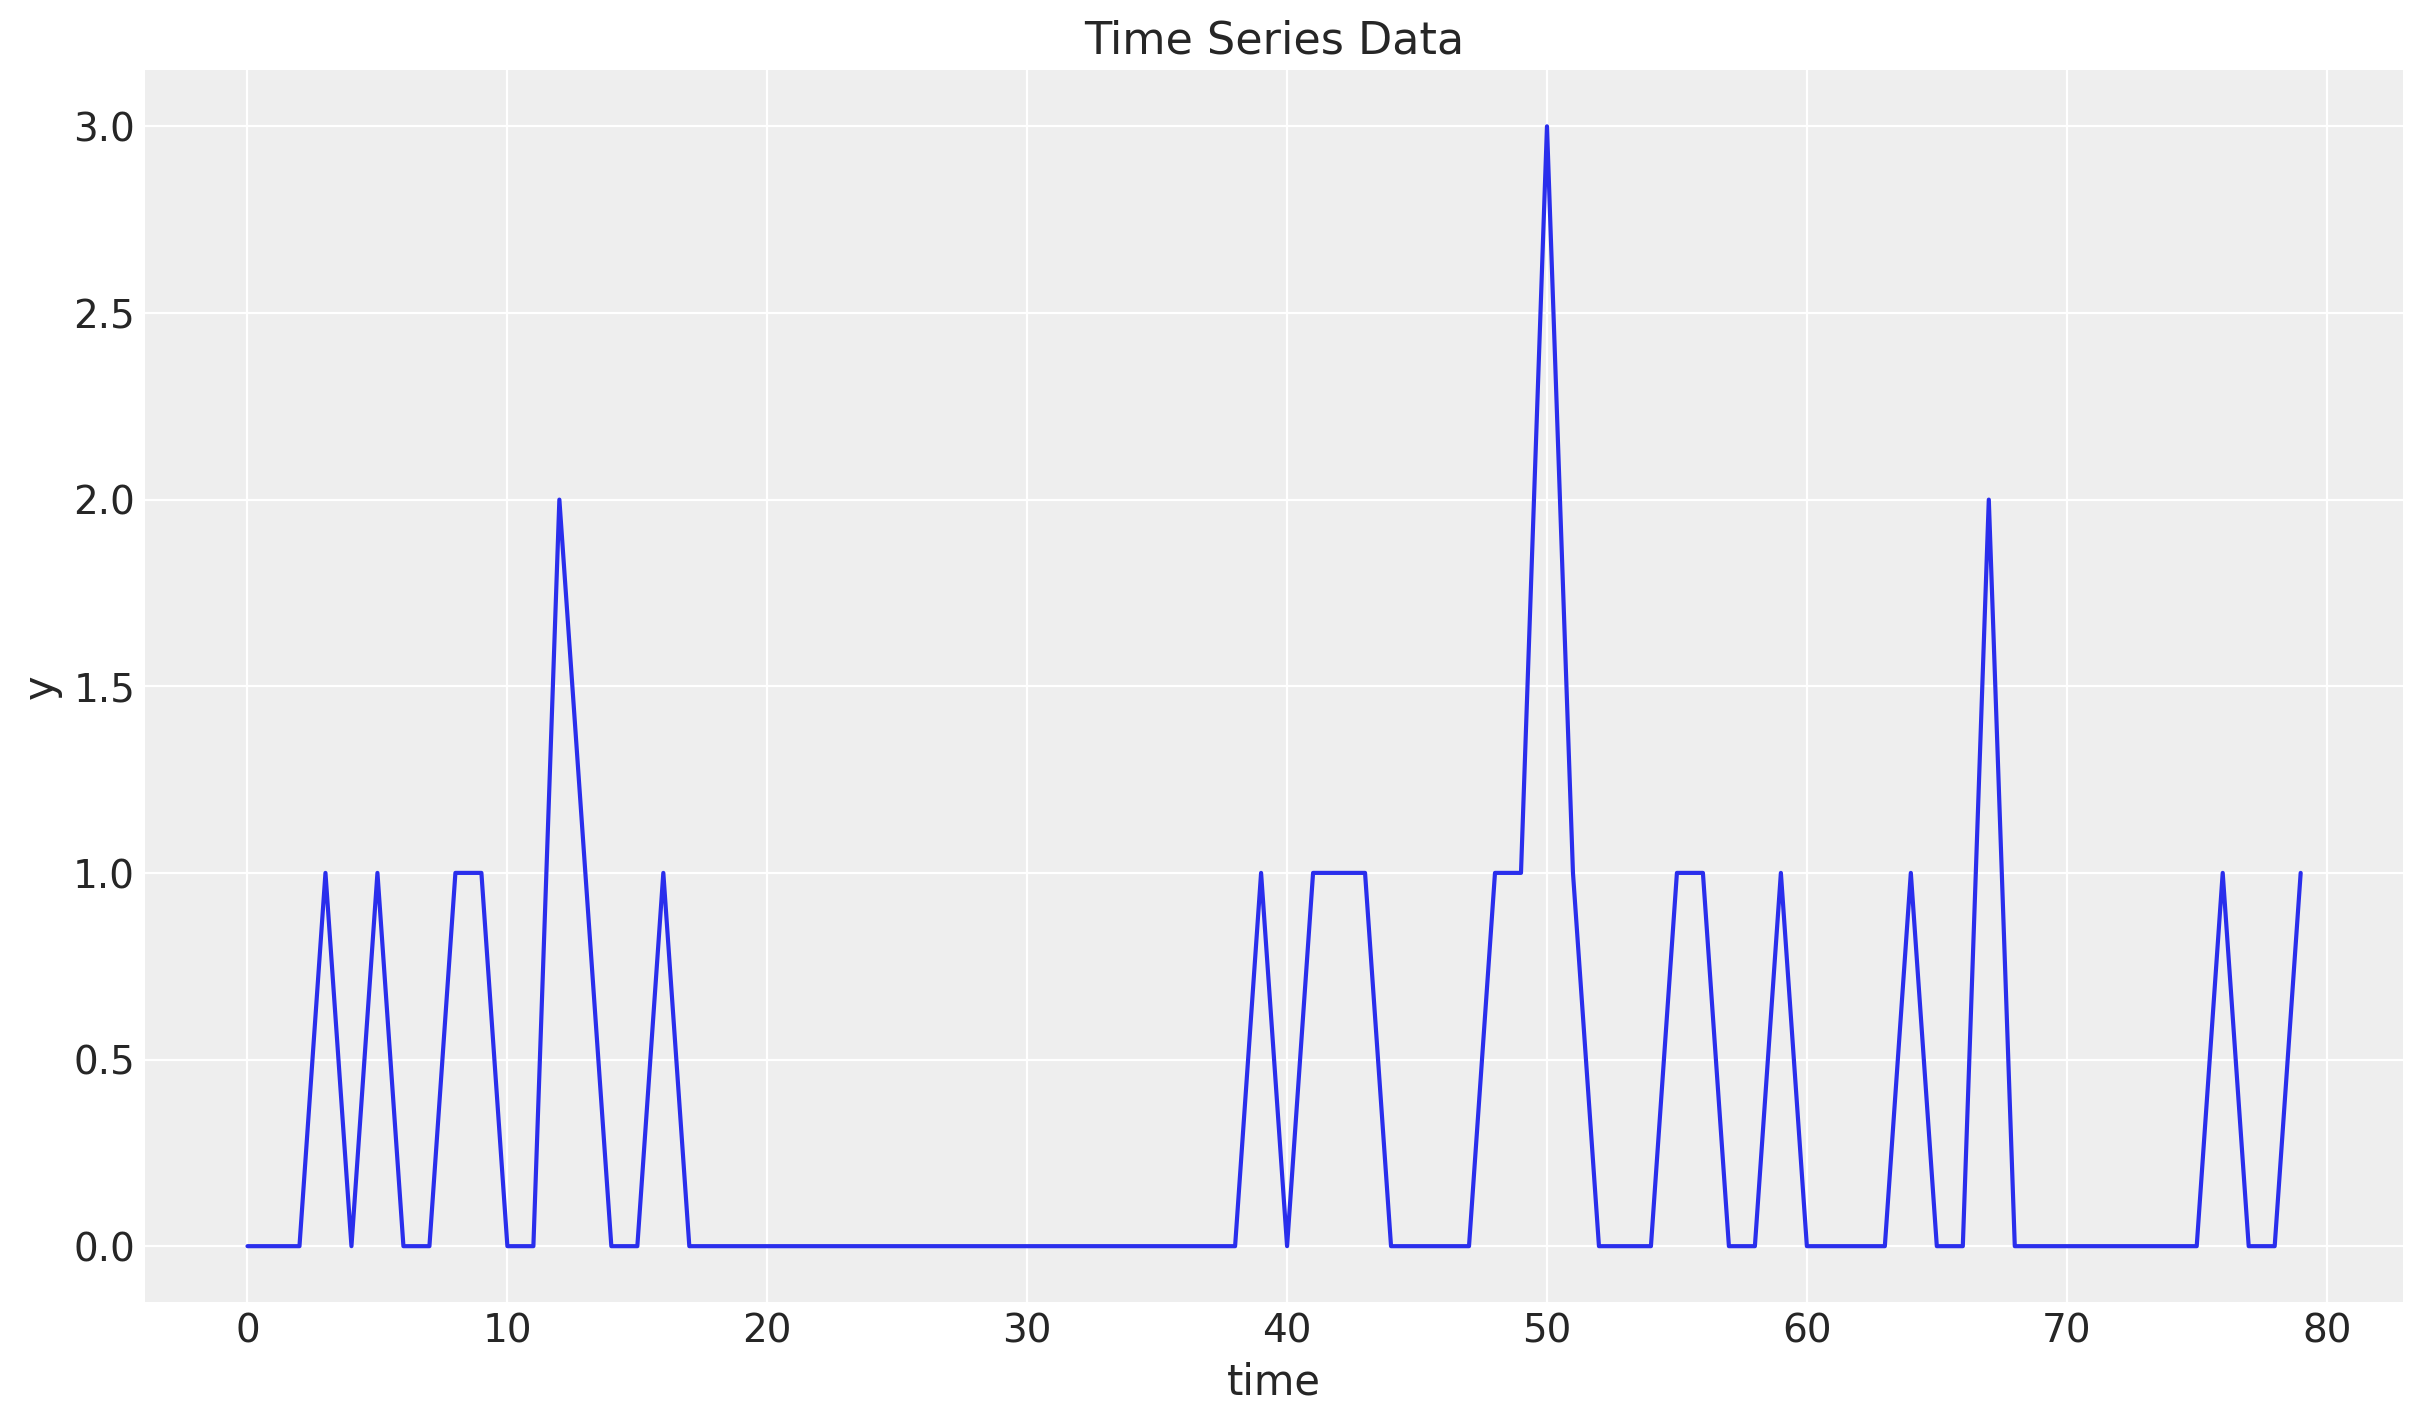

In [2]:
n = 80
lam = 0.3

y = random.poisson(key=rng_key, lam=lam, shape=(n,)).astype(jnp.float32)
t = jnp.arange(y.size)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

---

## Train-Test Split

Similarly as before we do a simple train-test split.

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

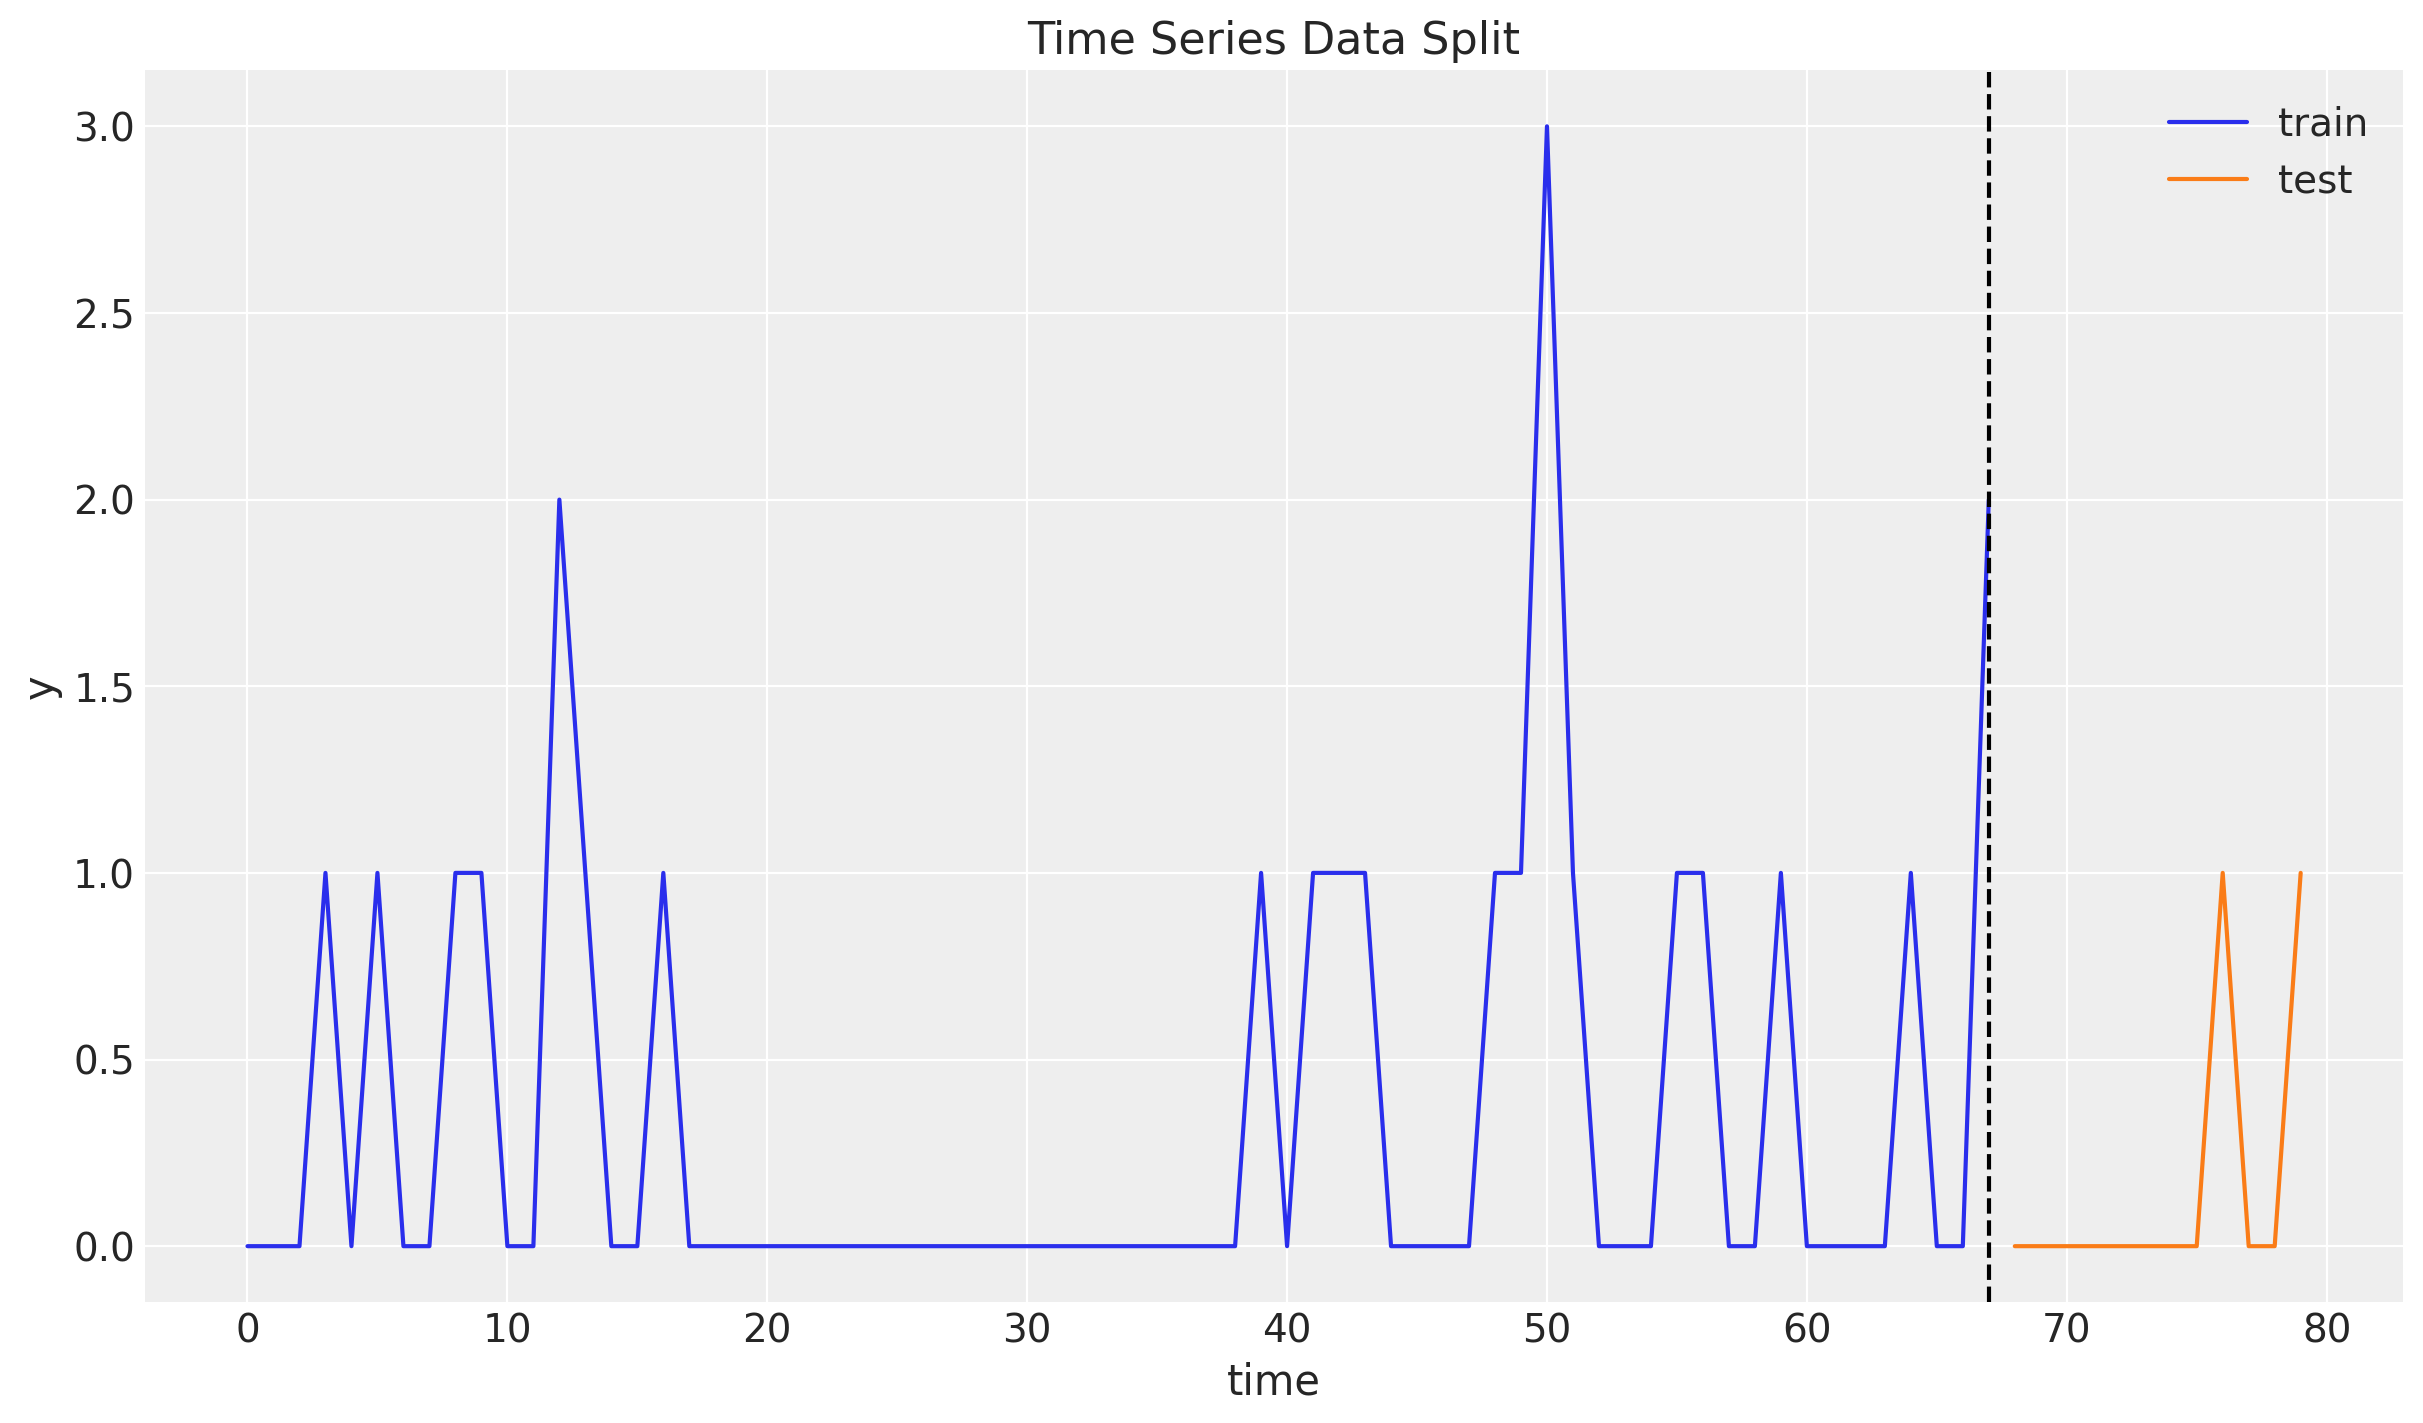

In [3]:
n = y.size

prop_train = 0.85
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

---

## Croston and TSB Model with StatsForecast

For the sake of comparison, let's start by looking into the results of the  [`statsforecast`](https://nixtlaverse.nixtla.io/statsforecast/index.html) package. We keep the parameters from the previous posts.

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

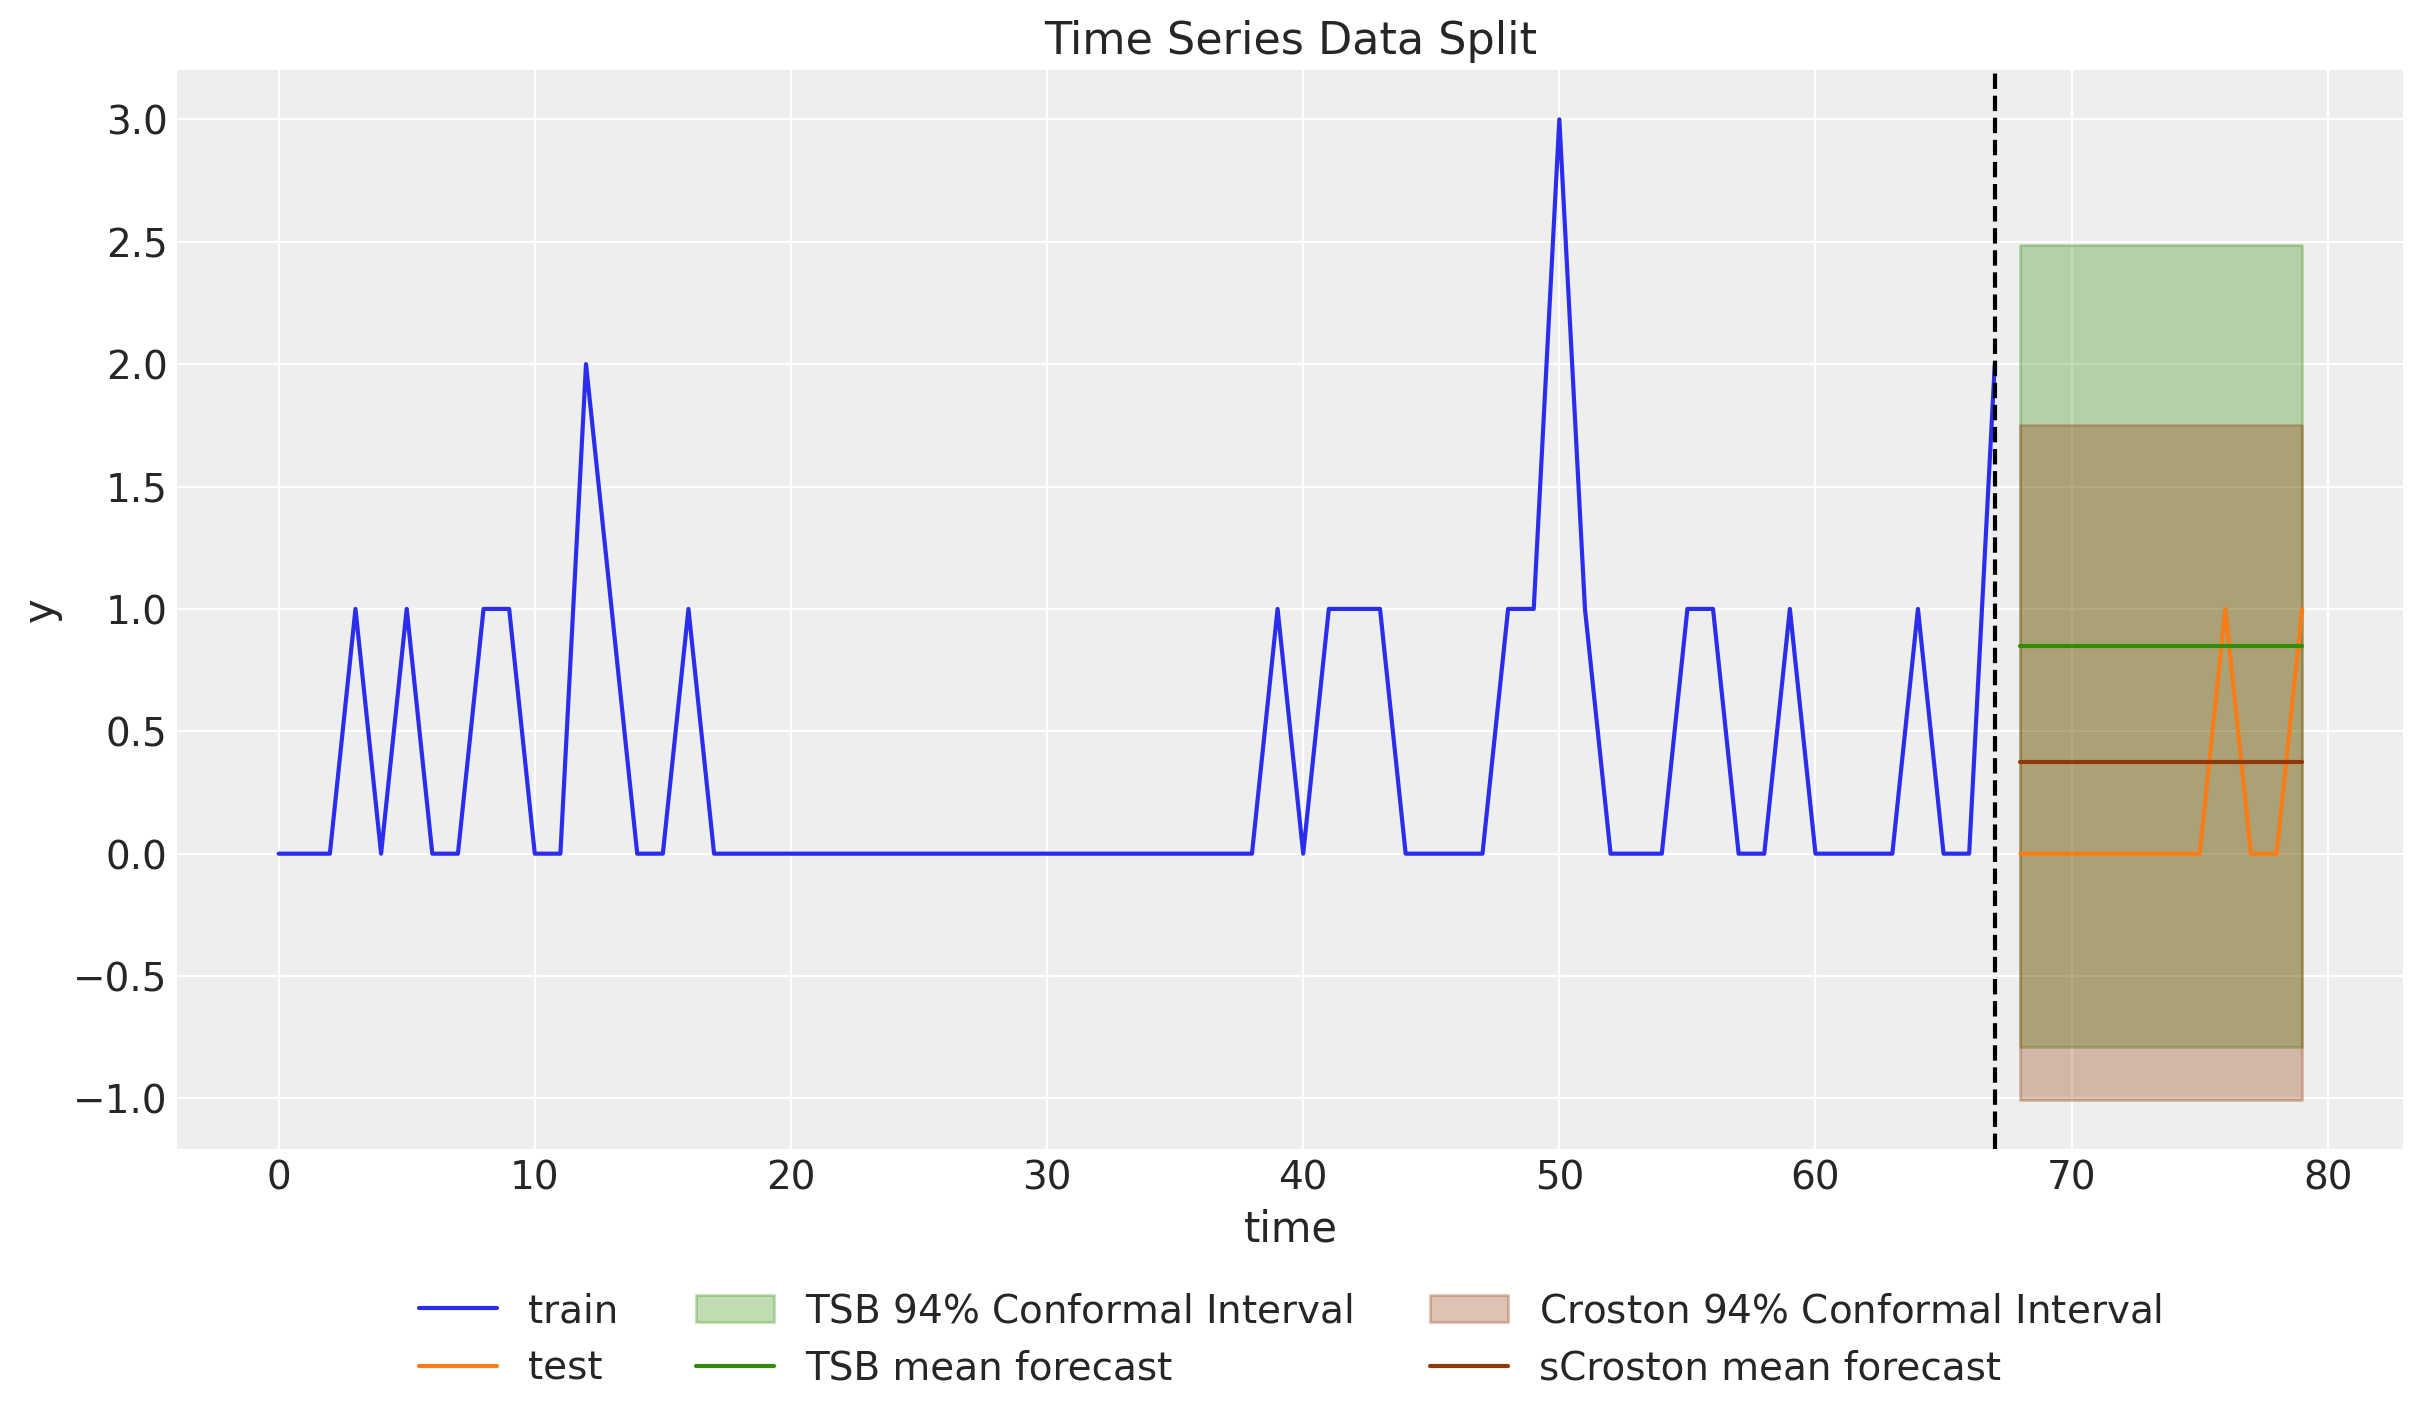

In [4]:
sf = StatsForecast(
    models=[CrostonOptimized(), TSB(alpha_d=0.311, alpha_p=0.57)],
    freq=1,
    n_jobs=-1,
)

train_df = pd.DataFrame({"unique_id": "a", "ds": t_train, "y": y_train})

sf_forecast = sf.forecast(
    h=y_test.size,
    df=train_df,
    level=[94],
    prediction_intervals=ConformalIntervals(n_windows=5),
)

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.fill_between(
    t_test,
    sf_forecast["TSB-lo-94"],
    sf_forecast["TSB-hi-94"],
    color="C2",
    alpha=0.3,
    label="TSB $94\\%$ Conformal Interval",
)
ax.plot(t_test, sf_forecast["TSB"], color="C2", label="TSB mean forecast")
ax.fill_between(
    t_test,
    sf_forecast["CrostonOptimized-lo-94"],
    sf_forecast["CrostonOptimized-hi-94"],
    color="C4",
    alpha=0.3,
    label="Croston $94\\%$ Conformal Interval",
)
ax.plot(
    t_test, sf_forecast["CrostonOptimized"], color="C4", label="sCroston mean forecast"
)
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

As explained in the previous post, for this specific smoothing parameters the forecast in significantly higher then the Croston's method. The reason is that at the end of the training set we have a big spike.

---

## Zero-Inflated TSB Model with NumPyro

As described in the introduction, the structure of the Zero-Inflated TSB model is thee same as in the one presented in [TSB Method for Intermittent Time Series Forecasting in NumPyro](https://juanitorduz.github.io/tsb_numpyro/). We just change the likelihood structure.

### Prior Specification

For this specific case, we need to constrain the priors a bit by making the support of the Beta distribution close to $[0.05, 0.3]$.

[Text(0.5, 1.0, 'Beta(10, 60) PDF'), Text(0.5, 0, '$\\alpha$')]

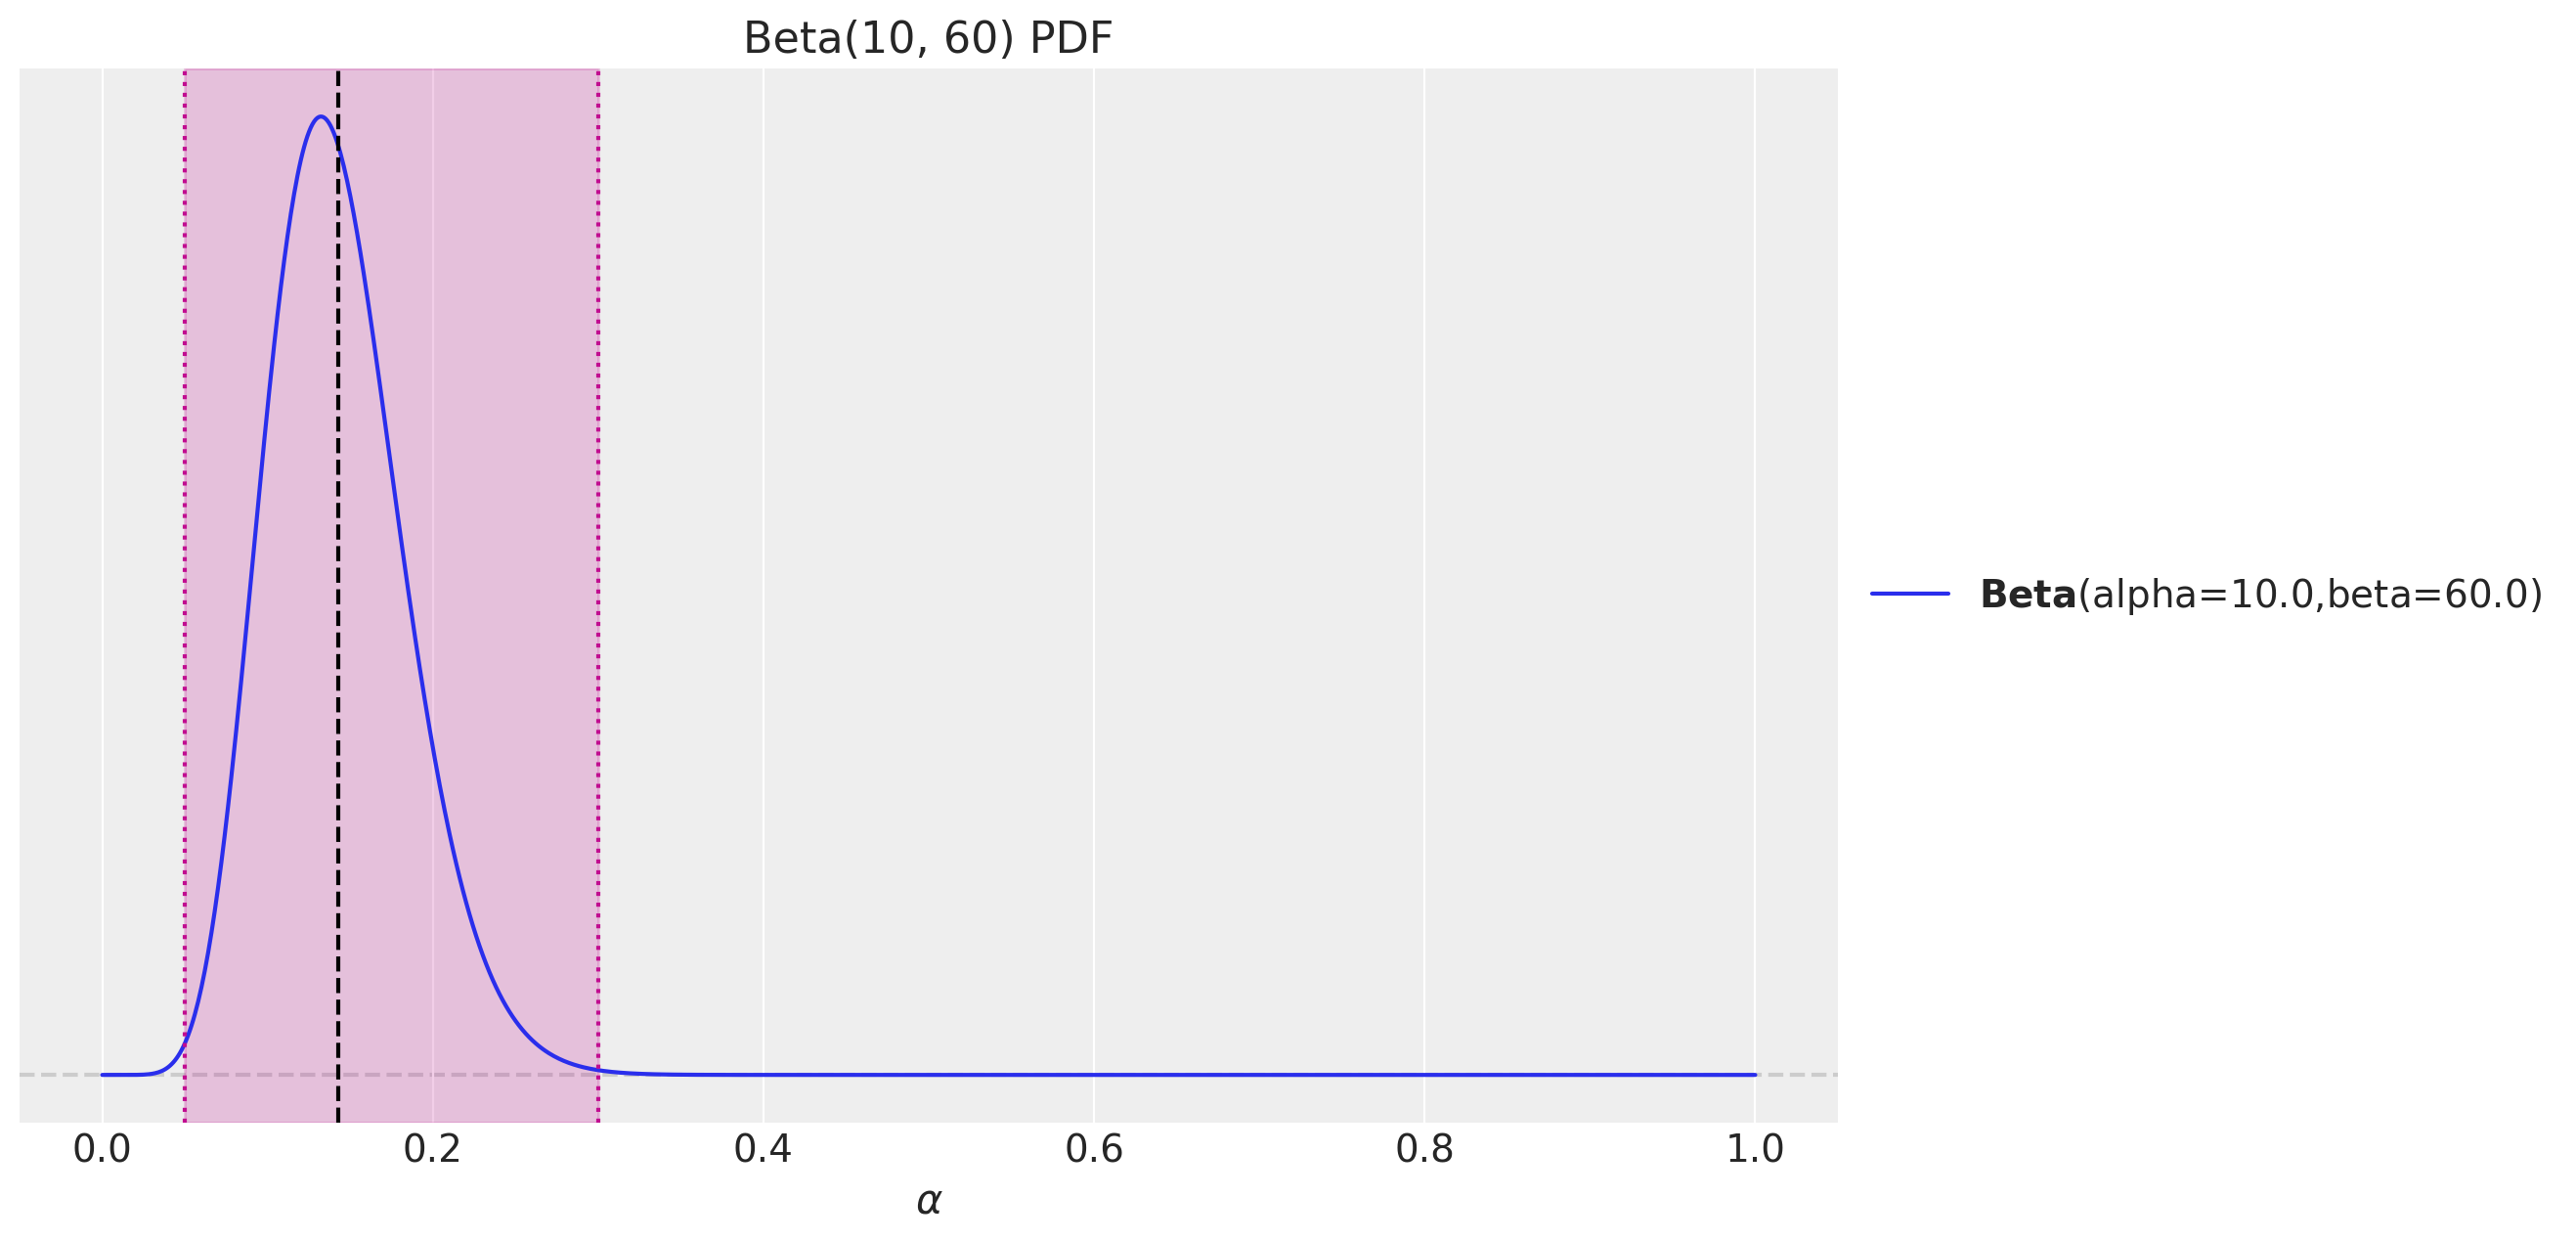

In [5]:
fig, ax = plt.subplots()
pz.Beta(10, 60).plot_pdf(ax=ax)
ax.axvline(x=(10 / (60 + 10)), c="black", linestyle="--")  # mean
ax.axvline(x=0.05, c="C3", linestyle=":")  # lower bound
ax.axvline(x=0.3, c="C3", linestyle=":")  # upper bound
ax.axvspan(xmin=0.05, xmax=0.3, color="C3", alpha=0.2)
ax.set(title="Beta(10, 60) PDF", xlabel="$\\alpha$")

### Model Specification

We now specify the model using the Zero-Inflated Negative Binomial likelihood function.

In [6]:
def zi_tsb_model(ts_trim: ArrayImpl, z0: float, p0: float, future: int = 0) -> None:
    t_max_trim = ts_trim.size

    # --- Priors ---

    z_smoothing = numpyro.sample(
        "z_smoothing", dist.Beta(concentration1=10, concentration0=60)
    )
    p_smoothing = numpyro.sample(
        "p_smoothing", dist.Beta(concentration1=10, concentration0=60)
    )
    concentration = numpyro.sample("concentration", dist.HalfNormal(scale=1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        z_prev, p_prev = carry

        z_next = jnp.where(
            t < t_max_trim,
            jnp.where(
                ts_trim[t] > 0,
                z_smoothing * ts_trim[t] + (1 - z_smoothing) * z_prev,
                z_prev,
            ),
            z_prev,
        )

        p_next = jnp.where(
            t < t_max_trim,
            jnp.where(
                ts_trim[t] > 0,
                p_smoothing + (1 - p_smoothing) * p_prev,
                (1 - p_smoothing) * p_prev,
            ),
            p_prev,
        )

        mu = z_next
        gate = 1 - p_next
        pred = numpyro.sample(
            "pred",
            dist.ZeroInflatedNegativeBinomial2(
                mean=mu, concentration=concentration, gate=gate
            ),
        )

        return (z_next, p_next), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": ts_trim}):
        _, preds = scan(
            transition_fn,
            (z0, p0),
            jnp.arange(t_max_trim + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("ts_forecast", preds[-future:])
    return None

### Inference

We now fit the model:

In [7]:
def get_model_args(y_train: ArrayImpl) -> tuple[ArrayImpl, float, float]:
    y_train_trim = jnp.trim_zeros(y_train, trim="f")
    p_idx = jnp.flatnonzero(y_train)
    p_diff = jnp.diff(p_idx, prepend=-1)
    z0 = y_train[p_idx[0]]
    p0 = 1 / p_diff.mean()
    return y_train_trim, z0, p0


class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc


y_train_trim, z0, p0 = get_model_args(y_train)

inference_params = InferenceParams()

rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(
    rng_subkey,
    zi_tsb_model,
    inference_params,
    y_train_trim,
    z0,
    p0,
)

idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
concentration,1.956,0.592,0.903,3.054,0.007,0.005,6240.0,4385.0,1.0
p_smoothing,0.245,0.053,0.147,0.345,0.001,0.000,7912.0,5831.0,1.0
z_smoothing,0.144,0.041,0.071,0.223,0.000,0.000,8171.0,5759.0,1.0


All diagnostics look good:

In [8]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'TSB Model Trace')

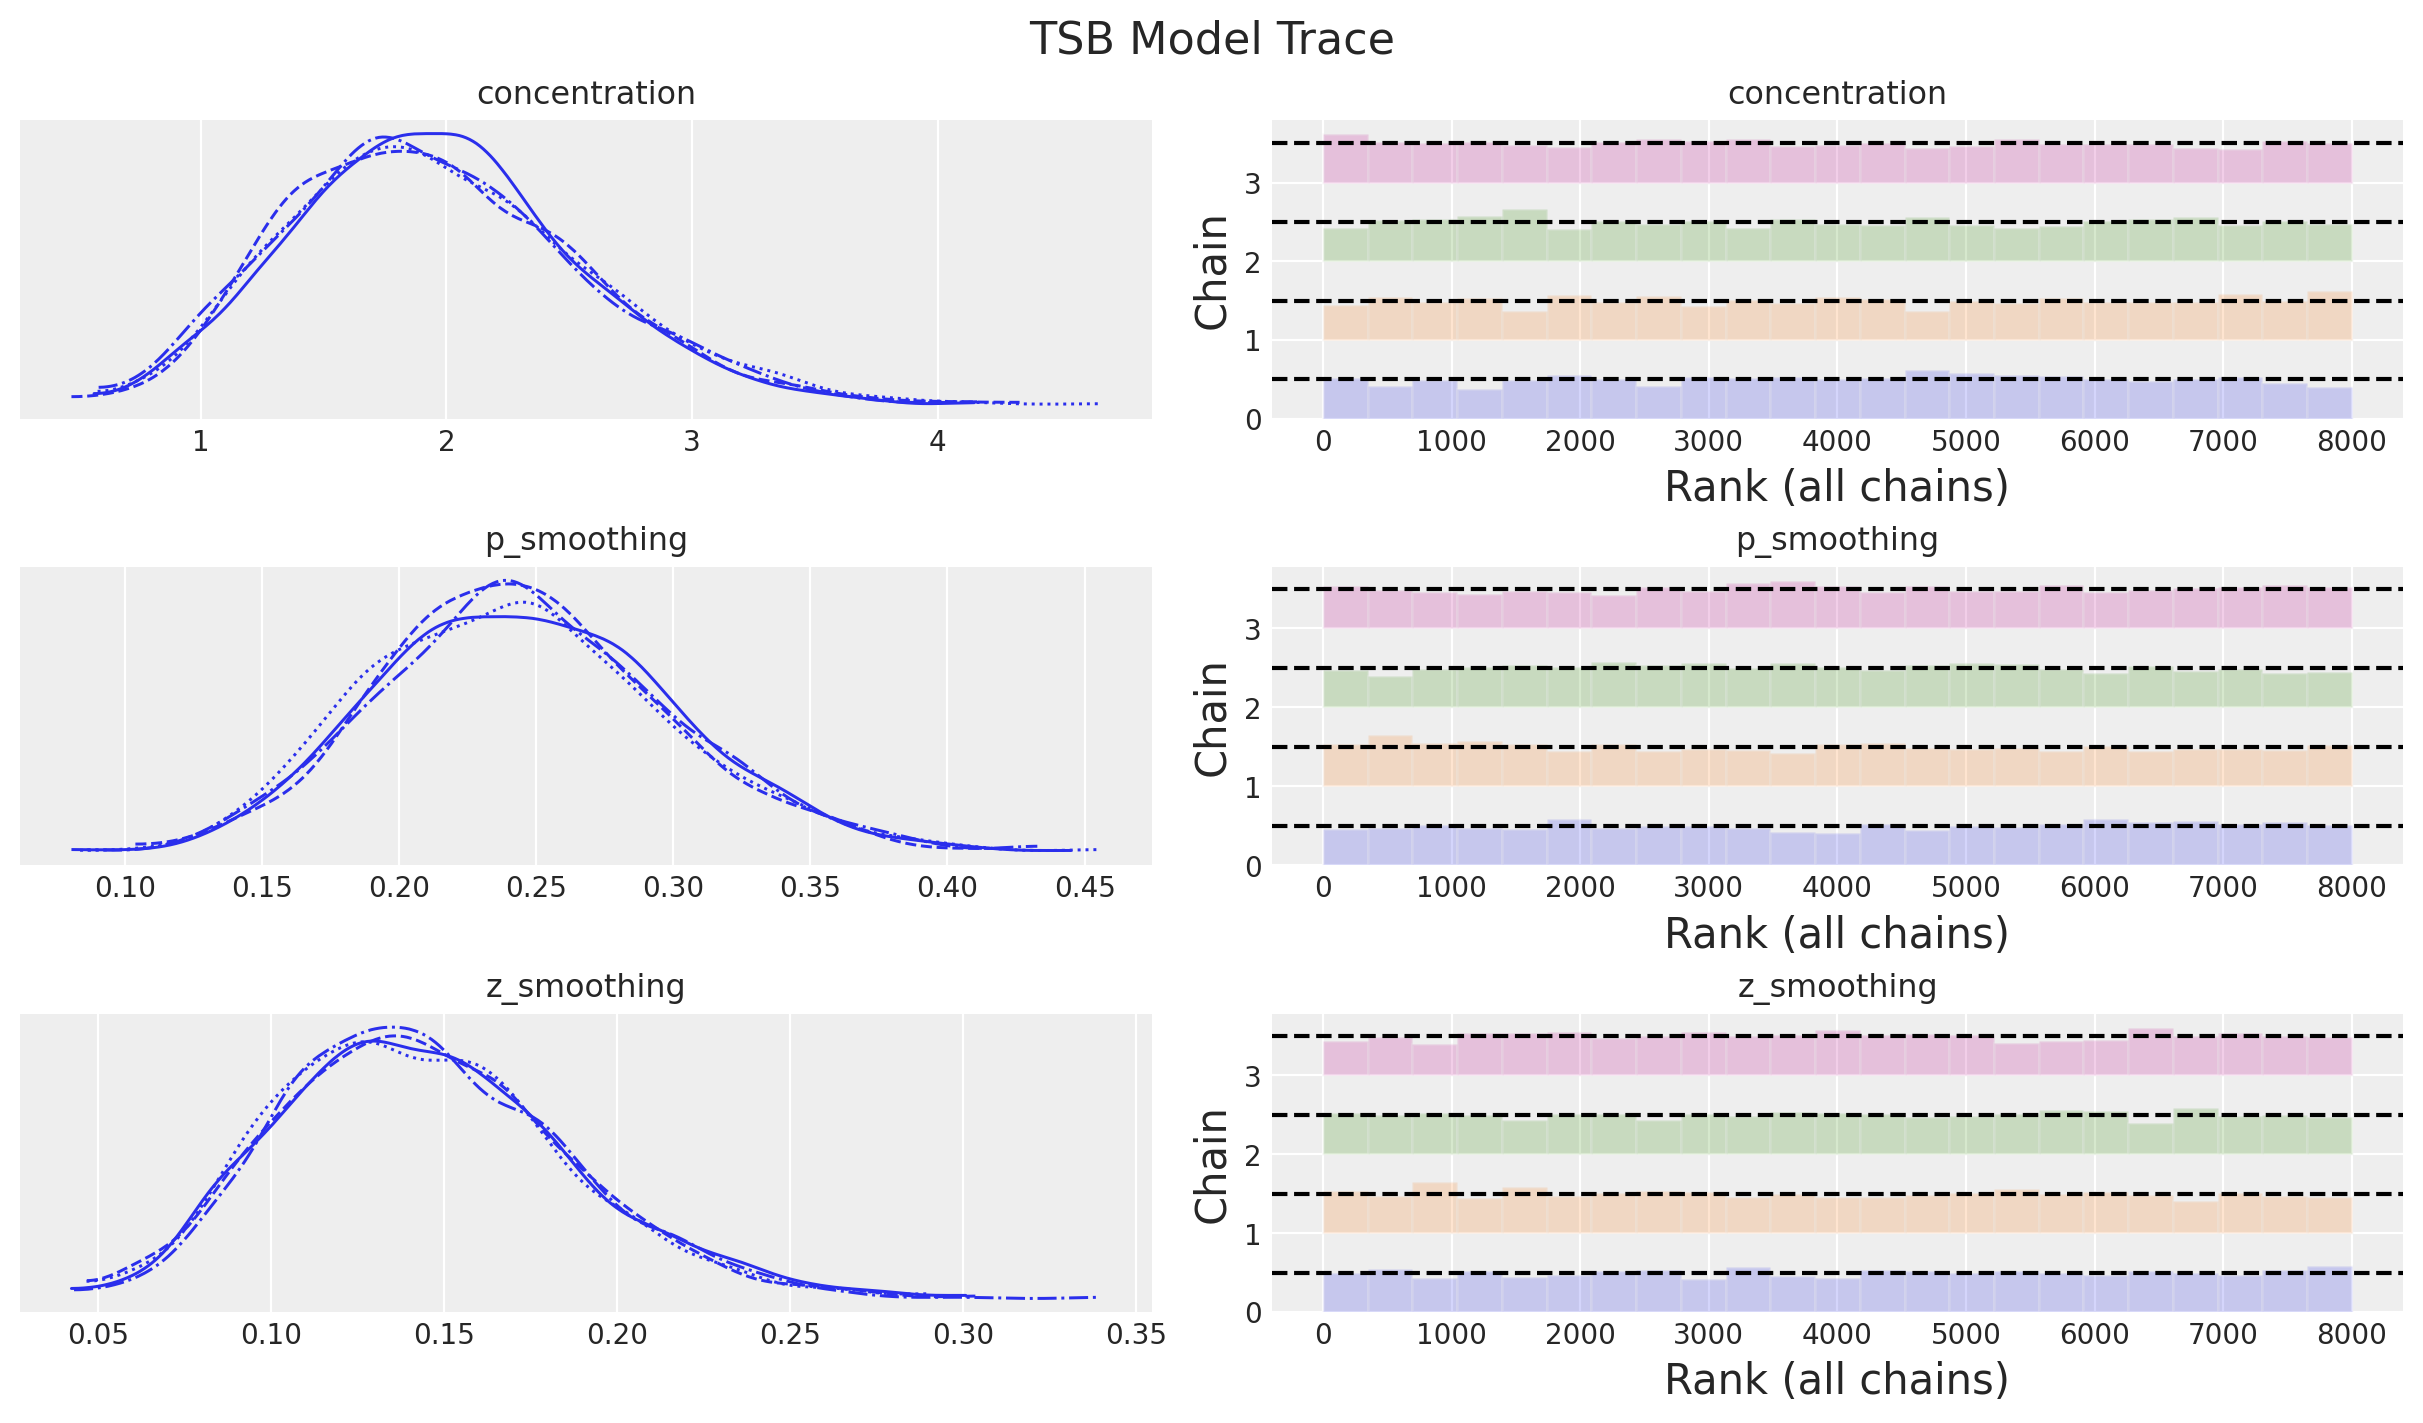

In [9]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("TSB Model Trace", fontsize=16)

### Forecast

We now generate the forecast:

In [10]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["ts_forecast"],
    )
    return predictive(rng_key, *model_args)


rng_key, rng_subkey = random.split(key=rng_key)
tsb_forecast = forecast(
    rng_subkey,
    zi_tsb_model,
    mcmc.get_samples(),
    y_train_trim.astype(jnp.int32),
    z0,
    p0,
    y_test.size,
)

posterior_predictive = az.from_numpyro(
    posterior_predictive=tsb_forecast,
    coords={"t": t_test},
    dims={"ts_forecast": ["t"]},
)

Let's see the forecast and compare it with the `statsforecast` models:

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'TSB Model Forecast')]

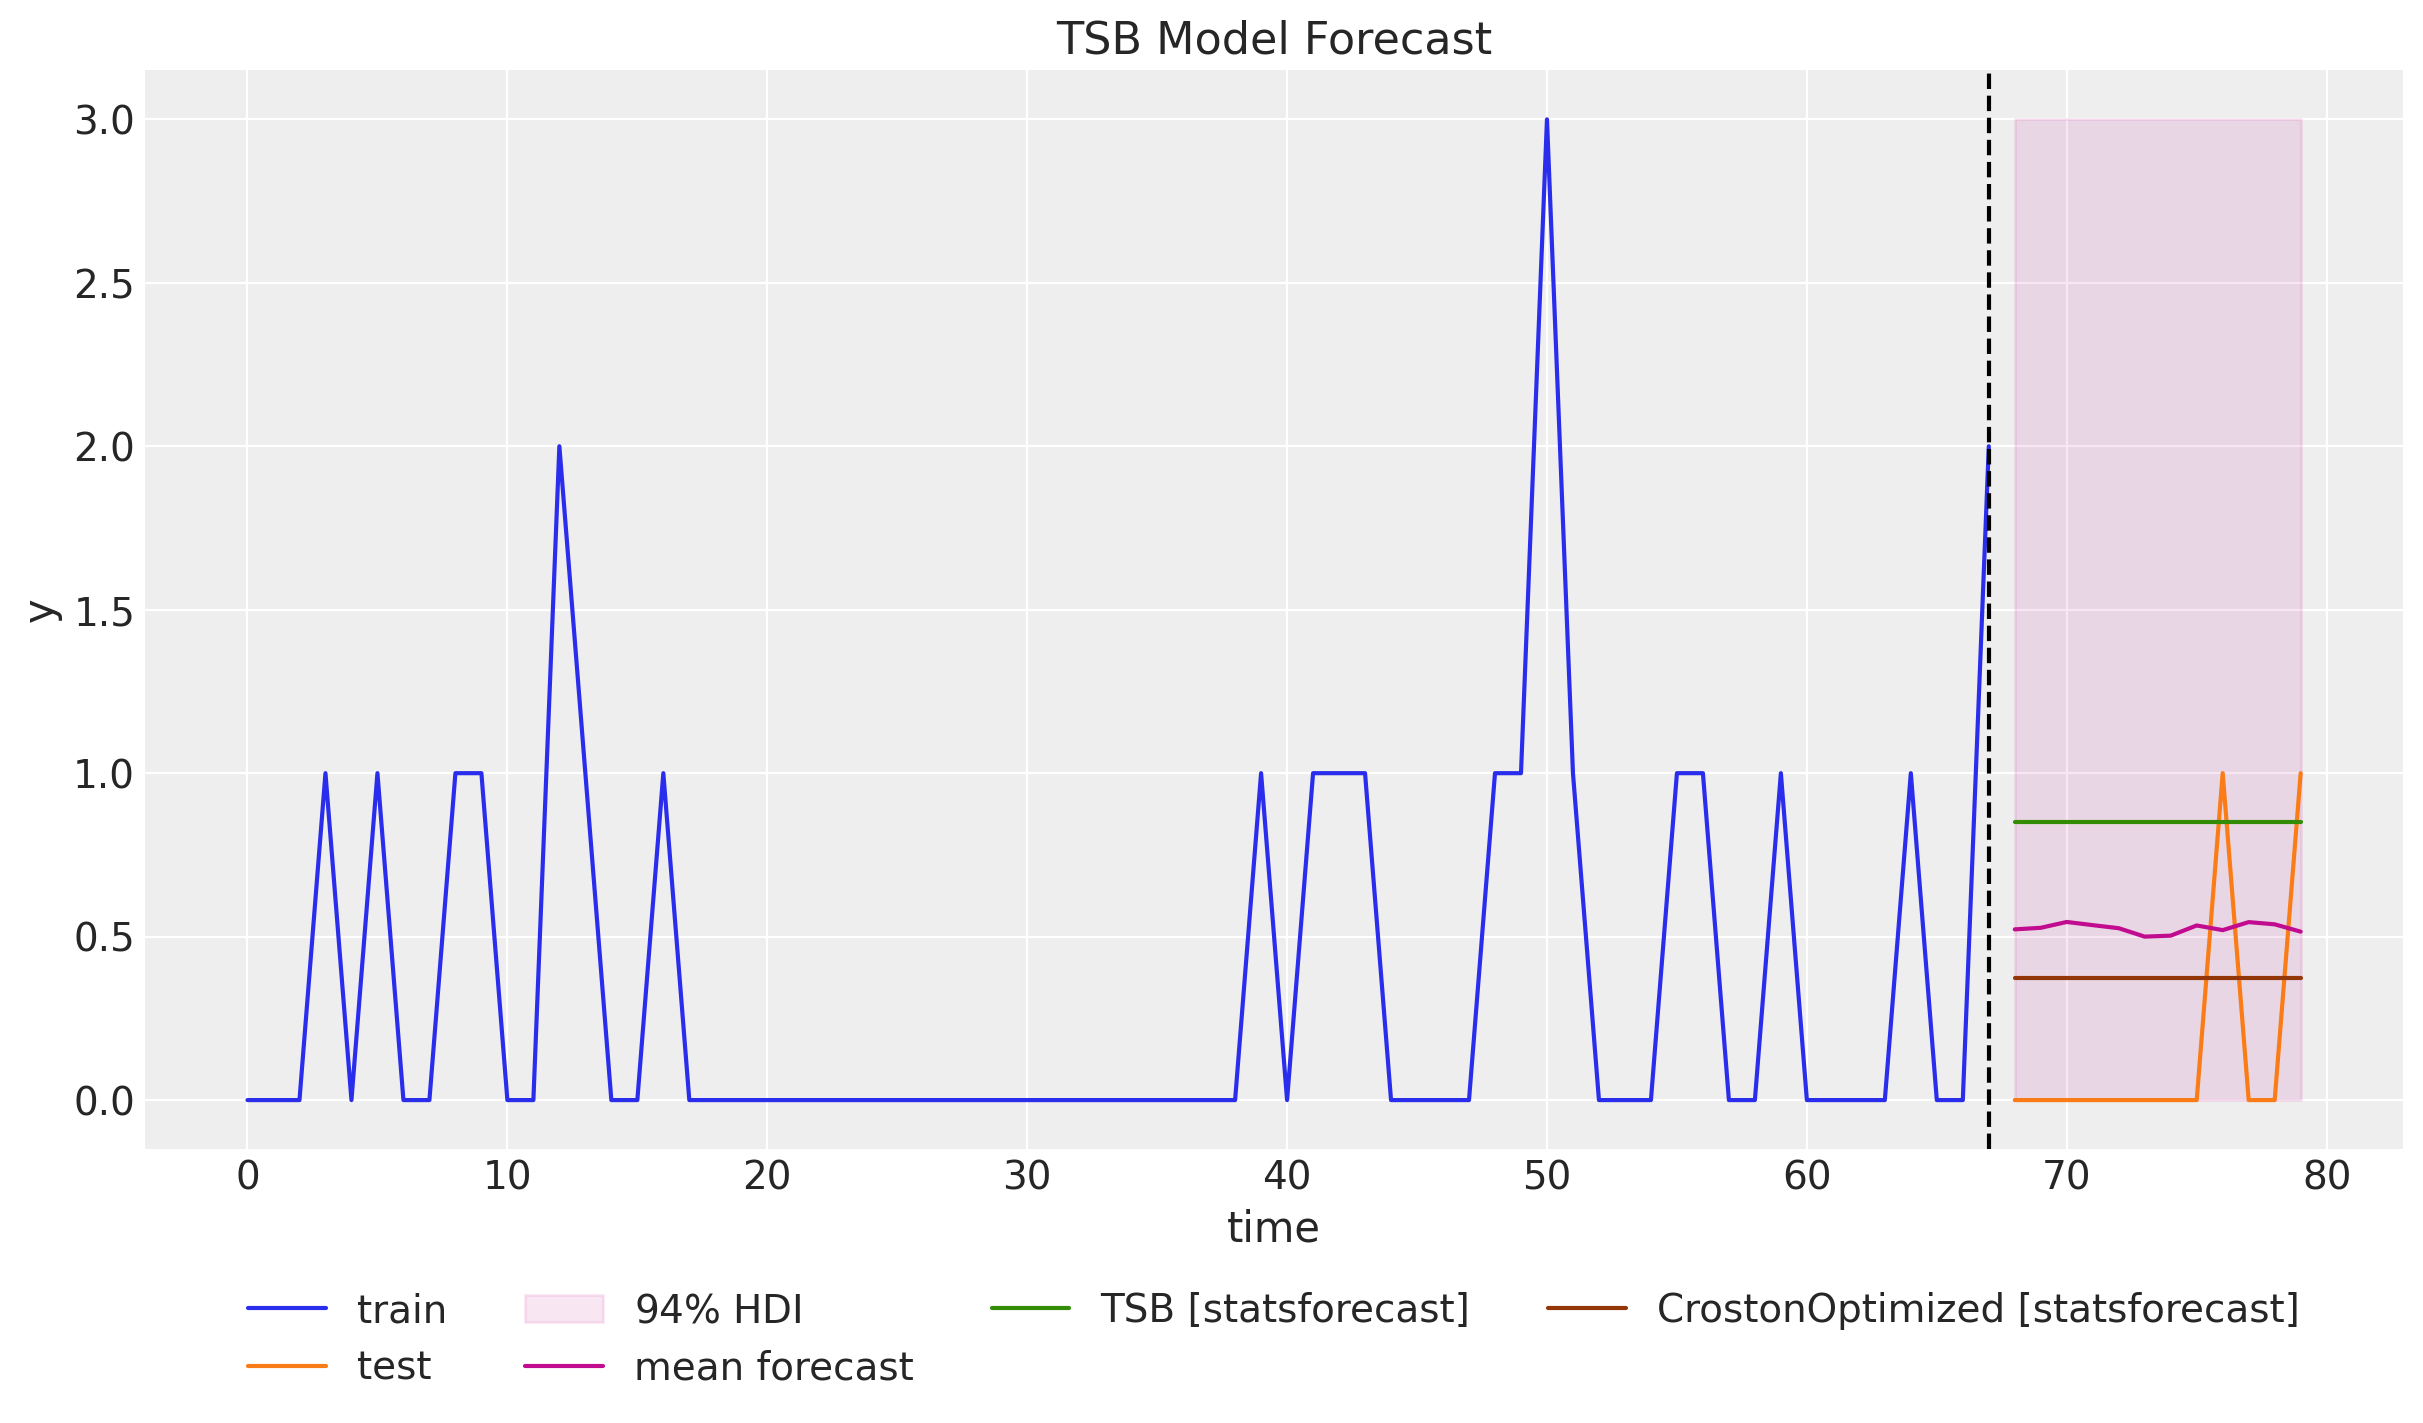

In [11]:
fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["ts_forecast"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.1, "label": "$94\\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["ts_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(t_test, sf_forecast["TSB"], color="C2", label="TSB [statsforecast]")
ax.plot(
    t_test,
    sf_forecast["CrostonOptimized"],
    color="C4",
    label="CrostonOptimized [statsforecast]",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="time", ylabel="y", title="TSB Model Forecast")

Observes that the mean forecast lies in between the Croston and TSB forecast.

We can zoom in into the one-step ahead forecast posterior distribution:

[Text(0.5, 1.0, 'Zero-Inflated TSB Model Forecast Posterior'),
 Text(0.5, 0, 'y'),
 Text(0, 0.5, 'Density')]

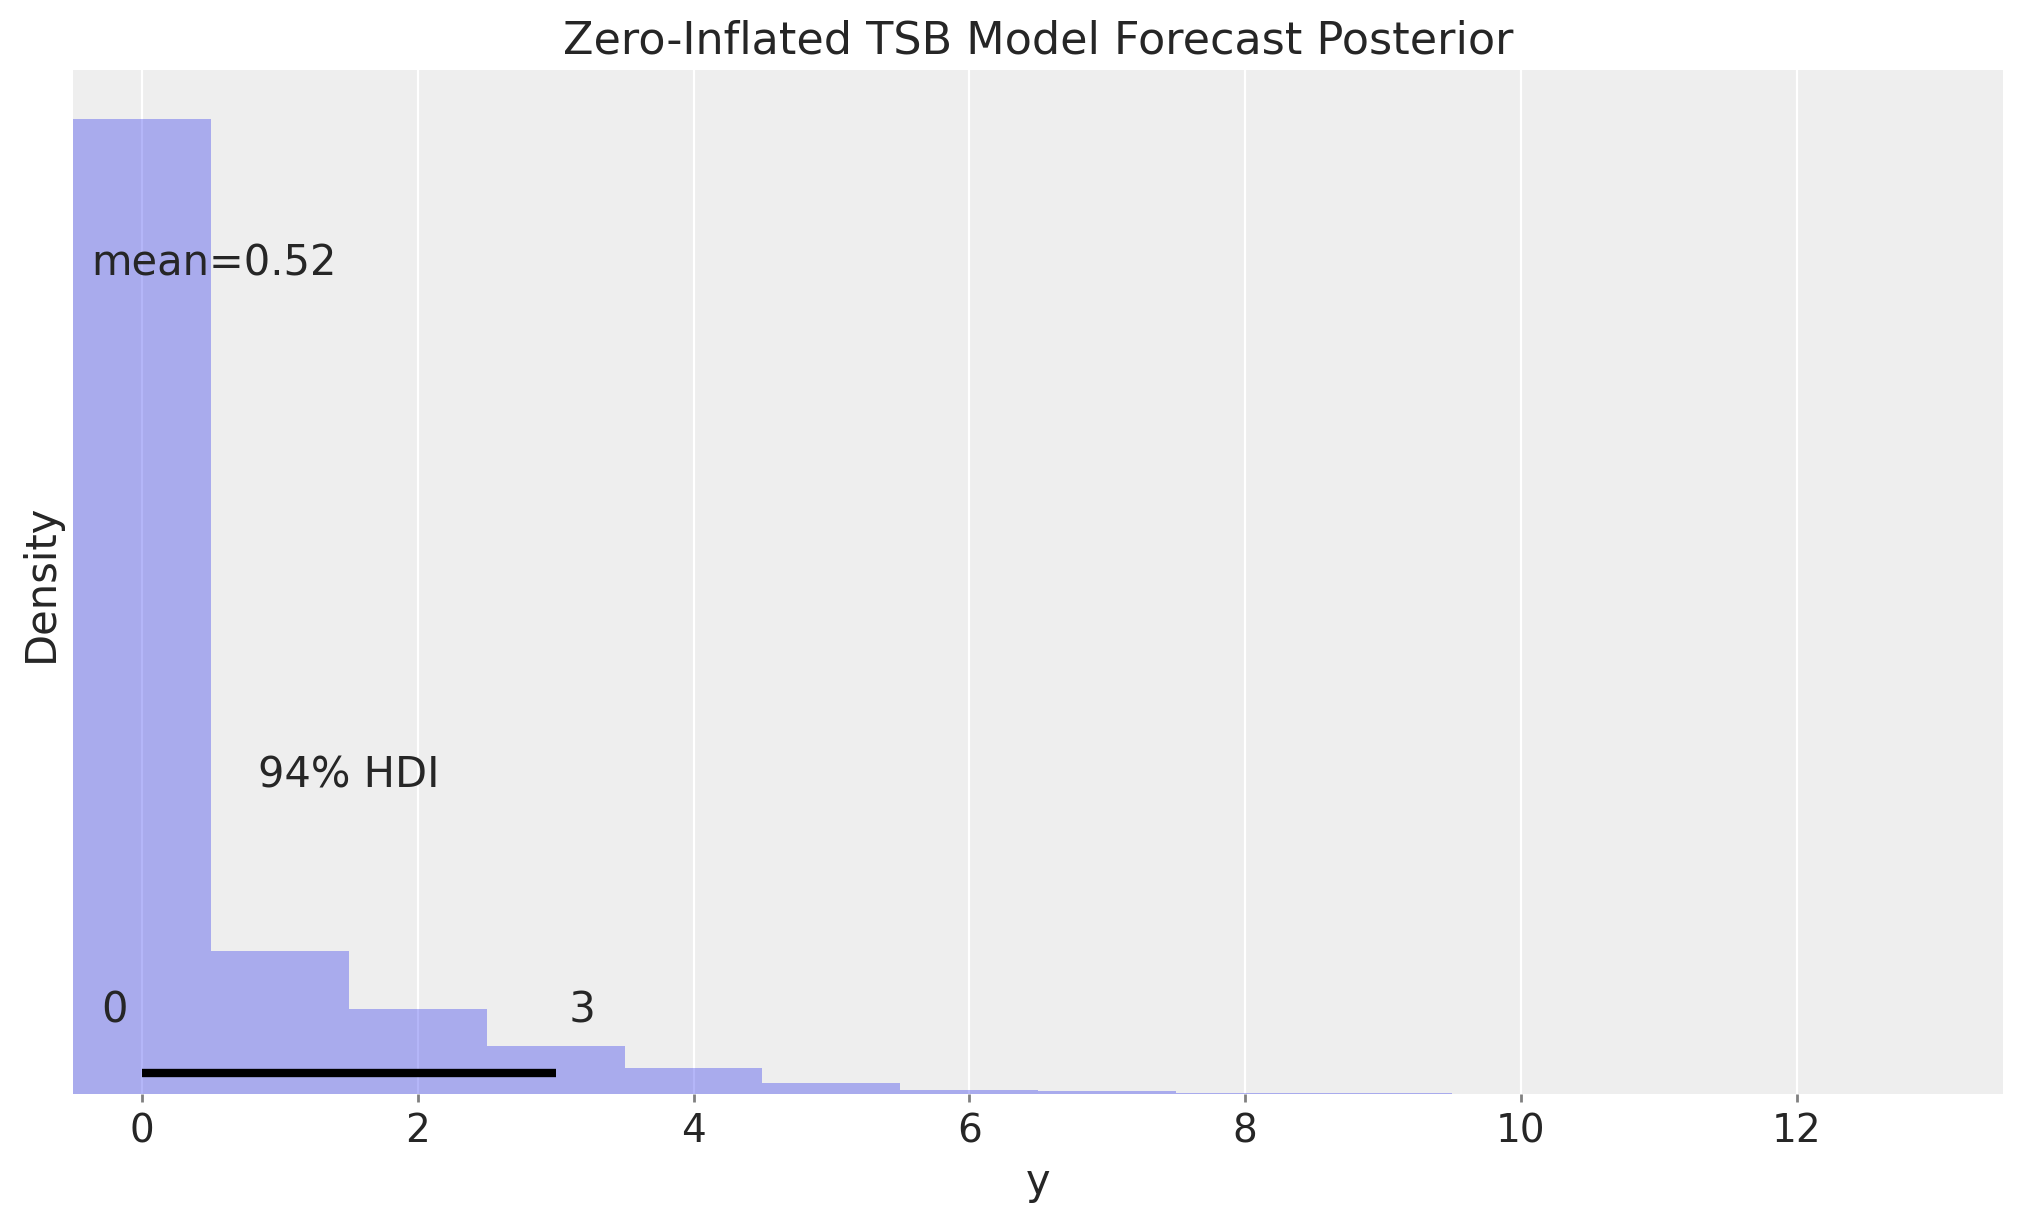

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_posterior(
    data=posterior_predictive["posterior_predictive"]["ts_forecast"].sel(t=n_train),
    ax=ax,
)
ax.set(
    title="Zero-Inflated TSB Model Forecast Posterior",
    xlabel="y",
    ylabel="Density",
)

Note that, in contrast to the Gaussian likelihood case, zero is in the $94\%$ credible interval. More over, it is in most of the credible intervals as the distribution is skewed to the right. This goes in alignment with the fact that the input time series is very sparse.

---

## Time Slice Cross Validation

Similarly as in the previous post, we run a time slice cross validation to compare the performance of the Zero-Inflated TSB model with the Croston and TSB models on the one-step ahead forecast.

- Statsforecast

In [13]:
def statsforecast_time_slice_cross_validation(
    y: ArrayImpl, n_splits: int, sf: StatsForecast
) -> pd.DataFrame:
    forecast_list = []
    for i in tqdm(range(n_splits)):
        y_train = y[: -(n_splits - i)]
        train_df = pd.DataFrame(
            {"unique_id": "a", "ds": jnp.arange(y_train.size), "y": y_train}
        )
        forecast_list.append(
            sf.forecast(
                h=1,
                df=train_df,
                level=[94],
                prediction_intervals=ConformalIntervals(n_windows=5),
            )
        )
    return pd.concat(forecast_list, axis=0)


sf_cv = statsforecast_time_slice_cross_validation(y=y, n_splits=y_test.size, sf=sf)

  0%|          | 0/12 [00:00<?, ?it/s]

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warning

In [14]:
def tsb_time_slice_cross_validation(
    rng_key: ArrayImpl, y: ArrayImpl, n_splits: int, inference_params: InferenceParams
) -> xr.Dataset:
    forecast_list = []
    for i in tqdm(range(n_splits)):
        # Prepare data
        y_train = y[: -(n_splits - i)]
        y_train_trim, z0, p0 = get_model_args(y_train)
        # Inference
        rng_key, rng_subkey = random.split(key=rng_key)
        mcmc = run_inference(
            rng_subkey,
            zi_tsb_model,
            inference_params,
            y_train_trim,
            z0,
            p0,
        )
        # Forecast
        rng_key, rng_subkey = random.split(key=rng_key)
        tsb_forecast = forecast(
            rng_subkey,
            zi_tsb_model,
            mcmc.get_samples(),
            y_train_trim.astype(jnp.int32),
            z0,
            p0,
            1,
        )
        forecast_list.append(
            az.from_numpyro(
                posterior_predictive=tsb_forecast,
                coords={"t": [y_train_trim.size]},
                dims={"ts_forecast": ["t"]},
            )
        )
    # Concatenate forecasts
    return xr.concat(
        [x["posterior_predictive"] for x in forecast_list],
        dim=("t"),
    )


rng_key, rng_subkey = random.split(key=rng_key)
forecast_cv = tsb_time_slice_cross_validation(
    rng_key=rng_subkey,
    y=y,
    n_splits=y_test.size,
    inference_params=inference_params,
)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We plot the results:

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Zero-Inflated TSB Model Forecast - 1 Step Ahead Cross-Validation')]

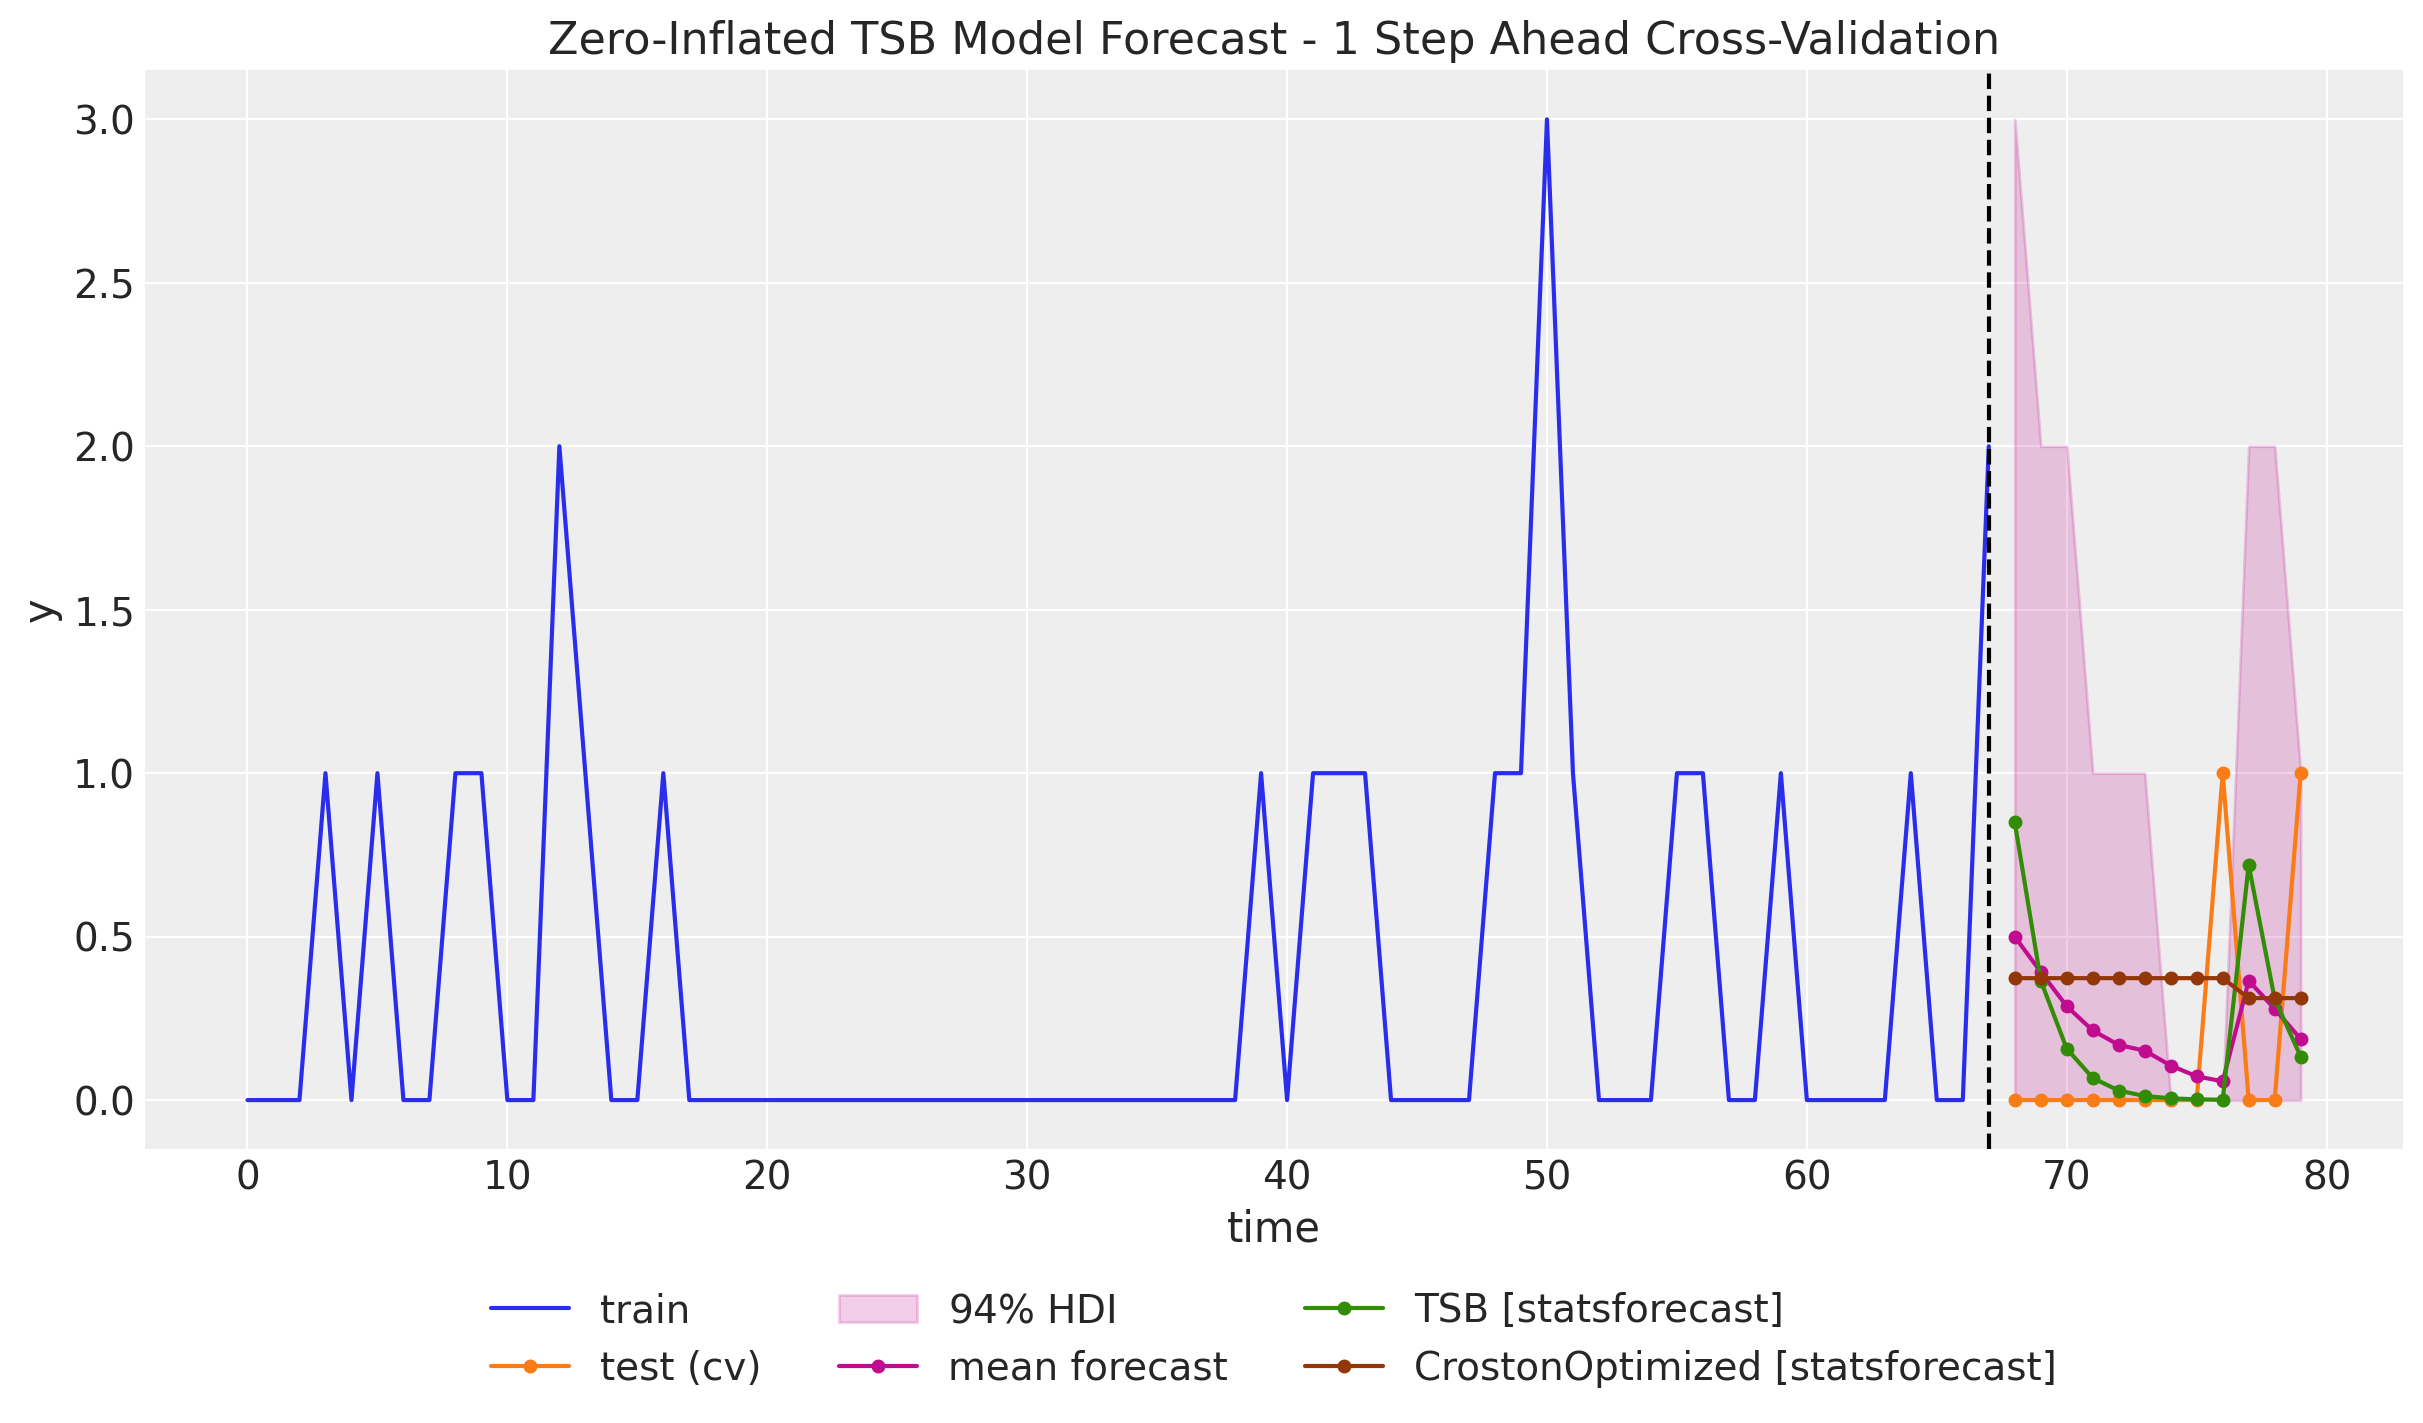

In [15]:
fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, marker="o", markersize=4, color="C1", label="test (cv)")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
az.plot_hdi(
    x=t_test,
    y=forecast_cv["ts_forecast"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    forecast_cv["ts_forecast"].mean(dim=("chain", "draw")),
    marker="o",
    markersize=4,
    color="C3",
    label="mean forecast",
)
ax.plot(
    t_test,
    sf_cv["TSB"],
    color="C2",
    marker="o",
    markersize=4,
    label="TSB [statsforecast]",
)
ax.plot(
    t_test,
    sf_cv["CrostonOptimized"],
    marker="o",
    markersize=4,
    color="C4",
    label="CrostonOptimized [statsforecast]",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(
    xlabel="time",
    ylabel="y",
    title="Zero-Inflated TSB Model Forecast - 1 Step Ahead Cross-Validation",
)

Here are some remarks about the results:

- The Zero-Inflated TSB model forecast lies in between the Croston's and TSB forecast. It keeps the property of updating the forecast when there is no demand as in the TSB model case. However, for the given parameters, the decay rate is much more conservative and goes to zero slower than the TSB model.
- The credible intervals take integer values (as we are assuming we are modeling count data) and they are never negative.

Depending on the application, and the forecasting metric to optimize for, the Zero-Inflated TSB model might be a better choice than the Croston's and TSB models as it somehow lies in between and the likelihood function better captures the discreteness of the input data. Note that this approach is relative natural once we write the model in a probabilistic programming language.